In [139]:
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
import os
import math
from torch.optim import Adam

In [140]:
data_55=pd.read_csv('./data/sample_data.csv')

In [143]:
def prof_categorization(test_55_label):
    test_55_label=np.array(test_55_label)
    test_55_label=(test_55_label-np.mean(test_55_label))/(np.max(test_55_label)-np.min(test_55_label))
    thresh=np.mean(test_55_label)
    test_55_label[test_55_label>=thresh]=1
    test_55_label[test_55_label<thresh]=0
    return test_55_label.tolist()

In [160]:
def data_process(data_2):
    
    X_data_2_Prof=data_2
    X_data_2_Prof_data = X_data_2_Prof.iloc[ : ,1:15] #training data
    X_data_2_Prof_data1=X_data_2_Prof_data.values.tolist()
    X_data_2_Prof_label1=X_data_2_Prof['per'].values.tolist()
    X_data_2_Prof_label1=prof_categorization(test_55_label)
    return X_data_2_Prof_data1, X_data_2_Prof_label1

In [161]:
def train_test_data(i,label):    
    
    test_data=(globals()["X_"+str(i)+"_"+label+"_data1"])+(globals()["X_"+str(i)+"_"+label+"_data1"])+(globals()["X_"+str(i)+"_"+label+"_data1"])+(globals()["X_"+str(i)+"_"+label+"_data1"])
    test_label=(globals()["X_"+str(i)+"_"+label+"_label1"])+(globals()["X_"+str(i)+"_"+label+"_label1"])+(globals()["X_"+str(i)+"_"+label+"_label1"])+(globals()["X_"+str(i)+"_"+label+"_label1"])

    return test_data, test_label

In [162]:
X_55_Prof_data1, X_55_Prof_label1=data_process(data_55)

In [163]:
test_55_data, test_55_label=train_test_data(55,"Prof")


In [164]:
def set_device():
    if torch.cuda.is_available():
        device="cuda"
    else:
        device="cpu"
    return torch.device(device)
device=set_device()

In [165]:
# class to represent dataset
class HeartDataSet():
  
    def __init__(self, data, label, transform):
        # train dataset
        self.data = data
        self.label=label
        self.transform=transform
        self.n_samples = len(data)
        
    def __len__(self):
        return self.n_samples 
    def __getitem__(self, index):
        data=self.data[index]
        label=self.label[index]
        temp_x1=self.transform(np.expand_dims(np.array(data), axis=0))
        temp_x1=temp_x1.squeeze(1)
        temp_y1=np.array(label)
        #temp_x1=(temp_x1-torch.mean(temp_x1))/(torch.max(temp_x1)-torch.min(temp_x1))
        del data
        return temp_x1, temp_y1
        
   
  


In [166]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=0., std=1.)])

In [167]:
class ProfNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Linear(14,20)
        self.conv2=nn.Linear(20,50)
        self.fc1=nn.Linear(50,30)
        self.fc2=nn.Linear(30,2)
        
    def forward(self,x):
        x=x.view(x.size(0),-1) 
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.fc1(x)
        x=self.fc2(x)
        return x

In [168]:
model=ProfNet().double().to(device)
ckpt=torch.load('./models/model_55.pth.tar')
model.load_state_dict(ckpt['model_55'])
model=model.to(device, non_blocking=True)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001,betas=(0.9, 0.999))
criterion=nn.CrossEntropyLoss()

In [169]:
data_te = HeartDataSet(test_55_data, test_55_label, transform=transform)
test_dataloader = DataLoader(dataset=data_te, batch_size=32, shuffle=True)

In [170]:
def evaluate_model(model, test_loader):
    model.eval() # moving the model from training mode to evaluation mode
    predicted_correctly_on_epoch=0
    total=0
    #device=set_device()
    
    orig=torch.empty(0).to(device)
    pred=torch.empty(0).to(device)
    proba=torch.empty([0,2]).to(device)
    # deactivate gradient computation
    with torch.no_grad():
        for data in test_loader:
            features, labels=data
            features=features.unsqueeze(1).to(device)  
            
            labels=labels.to(device)
            total+=labels.size(0)
            
            outputs=model(features.double())
            probs=torch.nn.functional.softmax(outputs)
            _, predicted=torch.max(outputs.data, 1)
            
            orig=torch.cat((orig, labels))            
            pred=torch.cat((pred, predicted))
            proba=torch.cat((proba, probs), axis=0)
            

            
            predicted_correctly_on_epoch+=(predicted==labels).sum().item()
            
    epoch_acc=100.0*predicted_correctly_on_epoch/total
    
    print(" - Testing dataset. Got %d out of %d images correctly (%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_acc))
    return orig, pred, proba

In [186]:
def sens_spec_bin(orig, pred, proba, df, sector):
    original=orig.cpu().detach().numpy() # convert tensor to numpy array
    prede=pred.cpu().detach().numpy() # convert tensor to numpy array
    proba=proba.cpu().detach().numpy()
    cm=confusion_matrix(original, prede)
    sensitivity=cm[1,1]/(cm[1,0]+cm[1,1])
    specificity=cm[0,0]/(cm[0,0]+cm[0,1]) 
    accuracy=(cm[1,1]+cm[0,0])/orig.shape[0]
    
    
    
    y_proba=proba[:,1]
    

    fpr, tpr, _ = metrics.roc_curve(original,  y_proba)
    auc = metrics.roc_auc_score(original, y_proba)
    
    

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot([0, 1],[0, 1],'r-')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.legend(loc=4)
    plt.show()
    ValueDict = {'sector':sector, 'sensitivity': sensitivity, 'specificity': specificity, 'accuracy': accuracy, 'area under curve':auc}
    
    df=df.assign(**ValueDict)

    return  df

 - Testing dataset. Got 24 out of 36 images correctly (66.667%)


C:\Users\gupta\AppData\Local\Temp\ipykernel_11608\3060686746.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=torch.nn.functional.softmax(outputs)


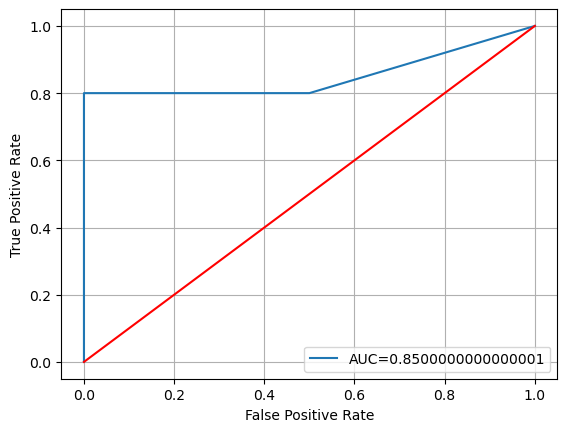

In [187]:
# 56 results
actual_gt, predictions, prediction_probs=evaluate_model(model, test_dataloader)
data55=pd.DataFrame(columns=['sector','sensitivity', 'specificity', 'accuracy', 'Average'])
data55=sens_spec_bin(actual_gt, predictions, prediction_probs,data55, 56)